# Supervised Learning on Congressional Voting

Supervised machine learning will be applied to explore the voting dataset obtained from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)  that consists of votes made by US House of Representatives Congressmen on 16 key issues in 1984. The goal is to predict their party affiliation ('Democrat' or 'Republican') based on how they voted on certain key issues. A classification model will be used.

## 1. Exploratory data analysis

As usual, before thinking about what supervised learning models to apply to this dataset, we need to perform exploratory data analysis (EDA) to understand the structure of the data. EDA normally consists of two parts: the numerical part and the graphical part. 

### 1.1 Numerical EDA

In [121]:
# Import modules
import pandas as pd
import numpy as np

# Read the voting data into a DataFrame: df
df = pd.read_csv('house-votes-84.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 17 columns):
party                435 non-null object
infants              435 non-null object
water                435 non-null object
budget               435 non-null object
physician            435 non-null object
salvador             435 non-null object
religious            435 non-null object
satellite            435 non-null object
aid                  435 non-null object
missile              435 non-null object
immigration          435 non-null object
synfuels             435 non-null object
education            435 non-null object
superfund            435 non-null object
crime                435 non-null object
duty_free_exports    435 non-null object
eaa_rsa              435 non-null object
dtypes: object(17)
memory usage: 57.9+ KB


The dataset has 435 rows and 17 columns, where 16 of the latter are features or predictor variables and one is the target variable (i.e. the 'party' column). It does not seem to have any missing data, but it is worth confirming by looking at the first few rows of data.

In [122]:
# Peak at the first 5 rows
df.head()

,party,infants,water,budget,physician,salvador,religious,satellite,aid,missile,immigration,synfuels,education,superfund,crime,duty_free_exports,eaa_rsa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


Note the missing data with '?'. Missing data will be cleaned in the preprocessing step below.

### 1.2 Graphical exploratory data analysis

It is a good idea to visualize the voting behavior between the two parties on some major issues.  'Education' and 'immigration' will be explored.

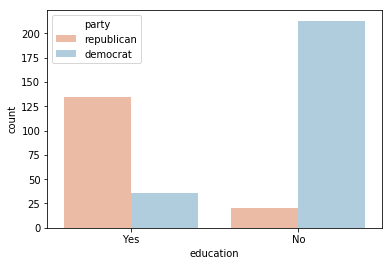

In [170]:
# Import modules
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Use seaborn's countplot to visualize 'education'
plt.figure()
sns.countplot(x='education', hue='party', data=df, palette='RdBu') #'RdBu' means 'Red' - Republican, and 'Blue' - Democrat.

# Label the ticks of x-axis
plt.xticks([0,1], ['Yes', 'No'])

# Show the plot
plt.show()

Note that Democrats voted against the education bill, while most of the Repulicans supported it. 

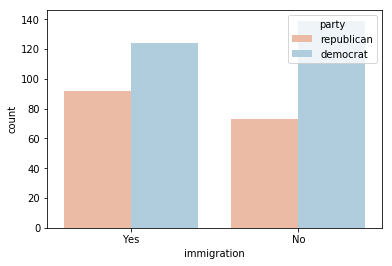

In [172]:
# Use seaborn's countplot to visualize 'immigration'
plt.figure()
sns.countplot(x='immigration', hue='party', data=df, palette='RdBu') #'RdBu' means 'Red' - Republican, and 'Blue' - Democrat.

# Label the ticks of x-axis
plt.xticks([0,1], ['Yes', 'No'])

# Show the plot
plt.show()

Since the counts of 'Yes' and 'No' votes were close for each party, the immigration bill seemed to be controversial. 

## 2. Preprocessing data

It was observed in EDA step that there are missing values in the data, encoded by '?'. One critical decision that comes to a data scientist's mind is whether to drop all missing data or impute it. This requires some exploration.

### 2.1 Dropping missing data

How about dropping all missing data and then comparing the shape of the new DataFrame to that of the original DataFrame?

In [173]:
# Convert '?' to NaN
df[df == '?'] = np.nan

# Print the number of NaNs
print(df.isnull().sum())

# Print shape of original DataFrame
print('\nShape of Original DataFrame: {}'.format(df.shape))

# Drop missing values and print the shape of the new DataFrame
df_new = df.dropna() # dropna() drops all rows with any missing data

# Print the shape of the new DataFrame
print('\nShape of DataFrame After Dropping All Rows with Missing Values: {}'.format(df_new.shape))


party                  0
infants               12
water                 48
budget                11
physician             11
salvador              15
religious             11
satellite             14
aid                   15
missile               22
immigration            7
synfuels              21
education             31
superfund             25
crime                 17
duty_free_exports     28
eaa_rsa              104
dtype: int64

Shape of Original DataFrame: (435, 17)

Shape of DataFrame After Dropping All Rows with Missing Values: (232, 17)


Dropping all missing data resulted in a DataFrame of nearly half of the size of the original one. When many values in the dataset are missing, dropping them might end up throwing away valuable information along with the missing data. Therefore, in this case, it would be better to develop an imputation strategy. Imputation means replacing missing values with the mean or the median of the row or column that the missing values are in.

In [174]:
# Check to confirm the missing values of the current DataFrame were replaced by 'NaN'
df.head()

,party,infants,water,budget,physician,salvador,religious,satellite,aid,missile,immigration,synfuels,education,superfund,crime,duty_free_exports,eaa_rsa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


### 2.2 Imputing missing data

From Section 2.1 above, the target variable, 'party', does not have any missing values, so this column does not need imputation. To impute the missing values in the feature array, we need to first generate the array. 
<br><br>We need to ensure the feature array and target variable adhere to the format required by the scikit-learn API. The features need to be in an array where each column is a feature and each row a different observation or data point - in this case, a Congressman's voting record. The target variable needs to be a single column with the same number of observations (i.e. rows) as the feature array.

In [175]:
# Create the feature array from 'df': X
X = df.iloc[:,1:]

# Print the first 5 rows
X.head()

,infants,water,budget,physician,salvador,religious,satellite,aid,missile,immigration,synfuels,education,superfund,crime,duty_free_exports,eaa_rsa
0,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


The classification machine learning model to be used will only accept numerical values, so the job here is to convert the categorical values, 'y' and 'n', to '1' and '0', respectively. The get_dummies() function of pandas can accomplish this.

In [176]:
# Convert categorical values to numerical ones
X = pd.get_dummies(X, drop_first=True)

# Print the first 5 rows
X.head()

,infants_y,water_y,budget_y,physician_y,salvador_y,religious_y,satellite_y,aid_y,missile_y,immigration_y,synfuels_y,education_y,superfund_y,crime_y,duty_free_exports_y,eaa_rsa_y
0,0,1,0,1,1,1,0,0,0,1,0,1,1,1,0,1
1,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,0
2,0,1,1,0,1,1,0,0,0,0,1,0,1,1,0,0
3,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,1
4,1,1,1,0,1,1,0,0,0,0,1,0,1,1,1,1


Note that 'NaN' has been replaced by '0', meaning a 'no' vote. Imputation is done! A better imputation strategy may be to replace 'NaN' with the most frequent value. 

Now it is time to generate the target variable, 'y'. It is worth noting that this has to be a 1-D array, not a DataFrame column. Therefore, we need to first create it from the 'df' DataFrame and then convert it to a 1-D NumPy array using the ravel() method.

In [177]:
# Create the target variable
y = df.iloc[:,:1].values

# Convert the target variable to a 1-D array
y = y.ravel()

## 3. Building the classification model

Having explored and preprocessed the dataset, it is time now to build the machine learning model, in this case, a classifier. The [k-Nearest Neighbors](http://scikit-learn.org/stable/modules/neighbors.html) (k-NN) classifier will be used.

In [178]:
# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X, y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')

Now that the k-NN classifier with 6 neighbors has been fit to the data, it can be used to predict the label of a new data point. However, there is no unlabeled data available, since all data was used to fit the model. Let's create a new, random unlabeled data point, and then use the current model to predict the label of it.

In [179]:
# Create a random unlabeled data point for prediction: X_new
X_new = np.array([0.450377, 0.127478, 0.344668, 0.557077, 0.85686, 0.636026, 0.484909, 0.394263, 0.469291, 0.086487, 0.460375, 0.24811, 0.315628, 0.555841, 0.092023, 0.405841])

# Re-format X_new to match the observation format
X_new = pd.DataFrame(X_new).transpose()

# Print the data
X_new

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.450377,0.127478,0.344668,0.557077,0.85686,0.636026,0.484909,0.394263,0.469291,0.086487,0.460375,0.24811,0.315628,0.555841,0.092023,0.405841


Referring back to the feature array, this data point may imply that this House member has a 45.04% chance to support the 'infants' bill, a 12.75% chance to support the 'water' bill, and so on. The goal is predict if this member is a republican or democrat.

In [180]:
# Predict and print the label for the new data point X_new
new_prediction = knn.predict(X_new)
print("Prediction: {}".format(new_prediction))

Prediction: ['democrat']


This member belongs to the Democrat party.

## 4. Measuring model performance

Now that we have created a classifier and used it to predict a House member's party based on his/her voting behavior, we would like to know how accurate our model is, i.e. what the chance of correct predictions is. Measuring the performance of the fitted model is an essential step in any machine learning project. 
<br><br>To measure the performance, we first split the dataset into training and test sets, fit the k-NN model to the training set, and then compute the accuracy using the .score() method.

In [182]:
# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

# Create a k-NN classifier with 6 neighbors: knn
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the training data
knn.fit(X_train, y_train)

# Print the accuracy
print(knn.score(X_test, y_test))

0.965517241379


This out of the box k-NN classifier with 6 neighbors has learned from the training data set and predicted the labels of the test data set with 97% accuracy! 

It would be interesting to find out if this model was overfitted or underfitted or what would be the best number of neighbors (k value) to use. We can compute and plot the training and testing accuracy scores for different k values. 

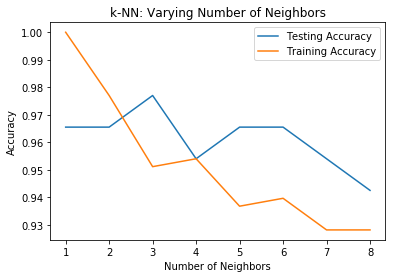

In [183]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9) # Try k values from 1 to 9
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

It looks like the test accuracy is highest when using 3 neighbors. Using more than 3 neighbors seems to result in underfitting the data. 
<br><br>Now let's go back to the model, change the k value to 3, and check if the prediction result will remain the same or change.

In [184]:
# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Create a k-NN classifier with 3 neighbors
knn = KNeighborsClassifier(n_neighbors=3)

# Fit the classifier to the data
knn.fit(X, y)

# Predict and print the label for the new data point X_new
new_prediction = knn.predict(X_new)
print("Prediction: {}".format(new_prediction))

Prediction: ['republican']


Notice that the prediction has changed to 'republican'! Since this modified model has higher accuracy, this result is more reliable.

## 5. Building a pipeline

As we have realized, there are quite a few steps to building a model, from imputing missing data, to creating training and test sets, to fitting a classifier and predicting a label for an unlabeled data point, and to evaluating the classifier's performance. Scikit-learn provides a [pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) constructor that allows us to put together these steps into one process and thereby simplify the workflow.

Let's now set up a pipeline with two steps: the imputation of missing data and instantiation of the k-NN classifier.

In [185]:
# Import necessary modules
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline

# Instantiate the k-NN classifier: knn
knn = KNeighborsClassifier(n_neighbors=3)

# Setup the pipeline steps: steps
steps = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
        ('clf', knn)]

# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline to the train set
pipeline.fit(X_train, y_train)

# Predict and print the label for the new data point X_new
new_prediction = knn.predict(X_new)
print("Prediction: {}".format(new_prediction))

Prediction: ['republican']


The pipeline function is very powerful! It has performed imputation and classification.

This project is concluded.